# LightGBM
Para usar o pacote LightGBM corretamente, é preciso ter instalado sua versão mais recente. Vamos fazer isso: 

1. Vá em file -> new -> terminal
2. Digite: sudo conda install lightgbm

In [2]:
# testando a instalação do pacote
# check lightgbm version
import lightgbm
print(lightgbm.__version__)

4.1.0


Como vimos, LightGBM é um framework que comporta algoritmos de classificação e regressão. Além disso, ele pode ser usado também para ranqueamento. Da mesma forma que o XGBoost, LightGBM apresenta uma série de parâmetros que podem ser otimizados.

Vamos trabalhar nessa parte com o modelo de regressão. Classificação será visto nos exercícios. Vamos acessar a documentação e entender alguns desses parâmetros [link](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html). 



In [3]:
#importando os pacotes necessários
import lightgbm as lgb
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas import DataFrame
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Vamos carregar os dados e analisar o DataFrame

In [4]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

df = DataFrame(X, columns= housing.feature_names)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


É possível encontrar mais informações desse dataset no seguinte [link](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)



In [5]:
# separando em conjunto de treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Agora precisamos definir os parâmetros para treinar um modelo usando a API para Python. Para consultar a documentação de como usar a API para Python, acesse esse [link](https://lightgbm.readthedocs.io/en/latest/Python-API.html#data-structure-api)

Para uma lista com os parâmetros que vamos utilizar e quais valores eles podem receber, use esse [link](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

In [6]:
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rate': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

É necessário carregar os dados no formato que a API do python espera. Para isso, usamos o método Dataset.

In [7]:
lgb_train = lgb.Dataset(x_train, y_train) #dados que serão usados para treino do modelo
lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train) #dados que serão usados para teste do modelo treinado

Com os dados no formato esperado, podemos realizar o treino do modelo usando os parâmetros estipulados. 

In [11]:
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_test,
                 callbacks=[
        lgb.early_stopping(stopping_rounds=30),
    ])

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.349561	valid_0's l2: 0.25464


Aqui, temos um novo parâmetro: *early_stopping_rounds*, que determina que o treino irá parar se uma métrica do conjunto de teste nao melhorar nas últimas n iterações (n, no nosso caso, é 30).

Vale notar que, por padrão, LightGBM executa 100 iterações (parâmetro *num_iterations*). 

In [12]:
# agora podemos obter as métricas
y_pred = model.predict(x_test)

# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

MSE: 0.25
RMSE: 0.50


Para entender melhor como nosso algoritmo se saiu, podemos plotar as respostas originais e as predições realizadas. O código abaixo faz isso:

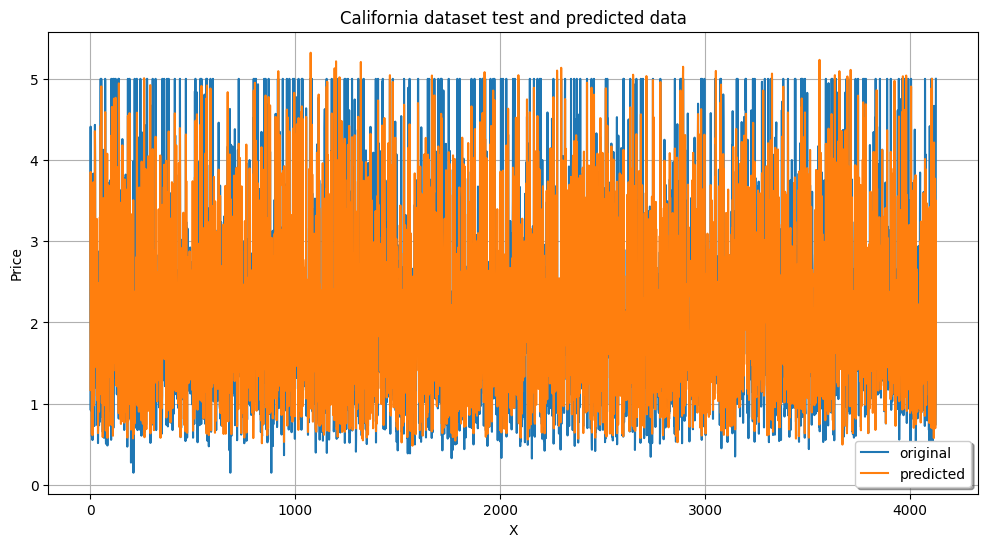

In [13]:
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("California dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

Podemos ver que nosso algoritmo se saiu muito bem, o que explica o erro baixo. 

Por último, LightGBM, assim como Random Forest, possui uma variável que nos fornece a importância de cada feature ao predizer a variável meta. Podmos acessá-la da seguinte forma:

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

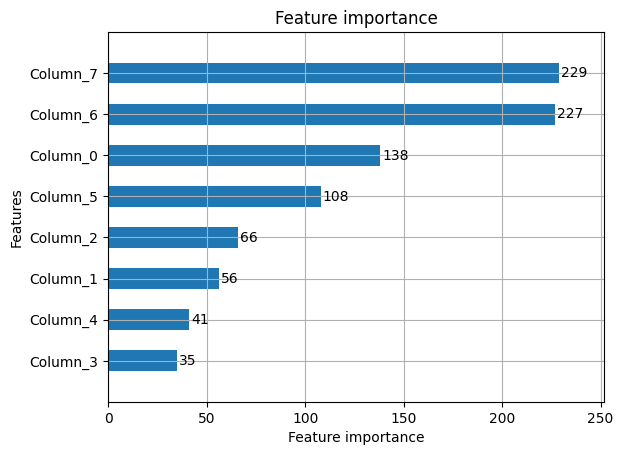

In [14]:
lgb.plot_importance(model, height=.5) 

Podemos melhorar um pouco a visualização adicionando o nome das features

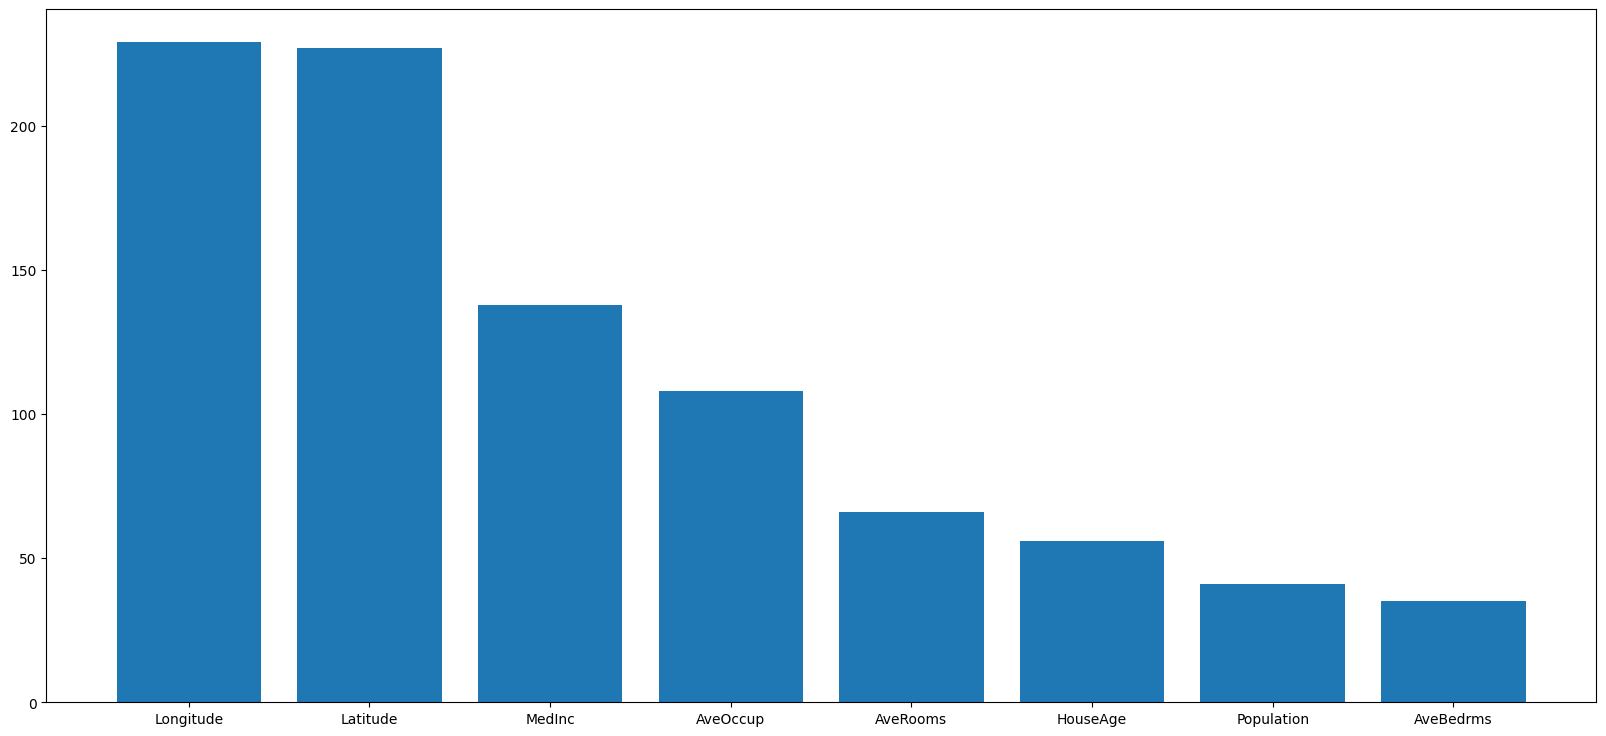

In [16]:
import numpy as np
import pandas as pd
plt.rcParams["figure.figsize"] = (20,9)
df_plot = pd.concat([pd.Series(housing.feature_names), pd.Series(model.feature_importance())], axis=1)
df_plot.columns = ['featureName', 'importance']
df_plot = df_plot.sort_values('importance', ascending=False)
x=np.arange(len(df_plot))
plt.bar(x,df_plot['importance'].values)
plt.xticks(x, np.array(df_plot['featureName']))
plt.show()